### 0.Imports

In [ ]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
import polars as pl

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

# Para realizar la regresión lineal y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression, HuberRegressor, Lasso
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer, root_mean_squared_error
from sklearn.model_selection import cross_validate

from sklearn.model_selection import KFold, RepeatedKFold,LeaveOneOut, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import RFE, RFECV
from skopt import BayesSearchCV

import statsmodels.api as sm

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer

# Vigilar progreso bucles
# -----------------------------------------------------------------------
from tqdm import tqdm

# Gestionar los warnings
# -----------------------------------------------------------------------
import warnings

# modificar el path
# -----------------------------------------------------------------------
import sys
import os
sys.path.append("..")

# crear archivos temporales
# -----------------------------------------------------------------------
import tempfile

# importar funciones de soporte
# -----------------------------------------------------------------------
import src.soporte_eda as se
import src.soporte_preprocesamiento as sp
import src.soporte_outliers as so
import src.ab_testing_support as ats

# evaluar objetos literales
# -----------------------------------------------------------------------
from ast import literal_eval 

# statistics functions
# -----------------------------------------------------------------------
from scipy.stats import pearsonr, spearmanr, pointbiserialr, norm


# Registro de modelos
# -----------------------------------------------------------------------
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

# Acceder a parámetros de métodos de objetos
# -----------------------------------------------------------------------
import inspect


seed = 42


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 0.1 Functions under construction

In [544]:
def model_evaluation_CV_run(run_name, models, scores, X, y, crossval, verbose=False):
    results = []

    n_splits = crossval.get_n_splits(X=X, y=y)

    warnings.filterwarnings('ignore')
    mlflow.autolog()

    with mlflow.start_run(run_name=f"{run_name} - Model Evaluation CV"):
        for name, model in models:
            # Start a child run for each model
            with mlflow.start_run(run_name=f"{name} - Model Evaluation CV", nested=True):

                mlflow.log_param("model_name", name)
                mlflow.log_param("cross_val_splits", n_splits)

                if verbose:
                    print(f"\nTraining {name}.")
                # Cross_val
                cv_results = cross_validate(model, X, y, cv=crossval, scoring=scores, verbose=verbose, return_train_score=True)

                # Store results for each fold and each metric
                for split in range(n_splits):
                    result = {"Model": name, "Split": split + 1}
                    for score in scores:
                        # prepare results_df
                        result[f"test_{score}"] = cv_results[f"test_{score}"][split]
                        result[f"train_{score}"] = cv_results[f"train_{score}"][split]

                    # log metrics
                    mlflow.log_metric(f"mean_test_{score}", cv_results[f"test_{score}"].mean())
                    mlflow.log_metric(f"std_test_{score}", cv_results[f"test_{score}"].std())
                    mlflow.log_metric(f"mean_train_{score}", cv_results[f"train_{score}"].mean())
                    mlflow.log_metric(f"std_train_{score}", cv_results[f"train_{score}"].std())
                    results.append(result)
                

                if verbose:
                    # Print results numerically
                    print(f'--\n{name} model:')
                    for score in scores:
                        print("%s: mean %f, std (%f) " % (score, cv_results[f"test_{score}"].mean(), cv_results[f"test_{score}"].std()))


        results_df = pd.DataFrame(results)
        log_dataframe_to_mlflow(results_df, artifact_path="test_results")

    warnings.filterwarnings('default')


    return results_df


def run_gridsearch_experiment(X_train, y_train, model_name, model, param_grid, cross_val, score, verbosity):
    with mlflow.start_run(run_name=f"GridSearch_CV_{model_name}"):

        # Dynamically set verbosity if supported
        if 'verbose' in inspect.signature(model.__init__).parameters:
            model.verbose = verbosity  

        grid_search = GridSearchCV(model, 
                                param_grid, 
                                cv=cross_val, 
                                scoring=score, 
                                n_jobs = -1,
                                verbose=verbosity)

        grid_search.fit(X_train, y_train)
    return {
        "model_name": model_name,
        "best_pipeline": grid_search.best_estimator_,
        "best_params": grid_search.best_params_,
        "best_score": grid_search.best_score_
    }


def run_bayessearch_experiment(X_train, y_train, model_name, model, param_space, cross_val, n_iter, score,verbosity, seed =42):
    with mlflow.start_run(run_name=f"BayesSearch_CV_{model_name}"):

        # Dynamically set verbosity if supported
        if 'verbose' in inspect.signature(model.__init__).parameters:
            model.verbose = verbosity  
        
        bayes_search = BayesSearchCV(estimator=model,
                                    search_spaces=param_space, 
                                    n_iter=n_iter, 
                                    cv=cross_val, 
                                    scoring=score,
                                    n_jobs=-1,
                                    random_state=seed)

        bayes_search.fit(X_train, y_train)
    return {
        "model_name": model_name,
        "best_pipeline": bayes_search.best_estimator_,
        "best_params": bayes_search.best_params_,
        "best_score": bayes_search.best_score_
    }



def plot_prediction_residuals(y_test, y_test_pred):

    fig, axes = plt.subplots(2,2, figsize=(15,8))
    axes = axes.flat

    sns.histplot(y_test_pred, bins=30, ax=axes[0], label="y_test_pred")
    sns.histplot(y_test, bins=30, ax=axes[0], alpha=0.25, label="y_test")
    axes[0].legend()
    axes[0].set_title('y_test vs y_test_pred distribution')

    axes[1].scatter(y_test.reset_index(drop=True), y_test_pred, color='purple')

    axes[1].axline((0, 0), slope=1, color='r', linestyle='--')
    axes[1].set_title('y_test Vs. y_pred')
    axes[1].set_xlabel('True values')
    axes[1].set_ylabel('Predicted values')


    residuals = y_test.values - y_test_pred

    sns.histplot(residuals, bins=30, ax=axes[2])
    axes[2].set_title('Residuals distribution')

    # Plot residuals
    axes[3].scatter(y_test_pred, residuals, color='purple')
    axes[3].axhline(0, linestyle='--', color='black', linewidth=1)
    axes[3].set_title('Residuals Plot')
    axes[3].set_xlabel('Predicted Values')
    axes[3].set_ylabel('Residuals')



    plt.tight_layout()
    plt.show()


def test_evaluate_model(run_name, model, X_train, y_train, X_test, y_test, best_params=None, tag=None,train_multiplier=1,test_multiplier=1):
    mlflow.autolog()

    with mlflow.start_run(run_name=f"{run_name} - test_evaluation") as run:
        modelo = model.set_params(**(best_params or {}))

        modelo.fit(X_train, y_train)

        y_train_pred = modelo.predict(X_train) * train_multiplier
        y_test_pred = modelo.predict(X_test) * test_multiplier
        y_train = y_train*train_multiplier
        y_test = y_test*test_multiplier

        mlflow.autolog(disable=True)
        metricas = calculate_train_test_metrics(y_train, y_test, y_train_pred, y_test_pred)

        # Registrar metricas a MLflow
        for train_test in metricas.keys():
            for metric_name, value in metricas[train_test].items():
                mlflow.log_metric(f"{train_test}_{metric_name}", value)

        mlflow.autolog()

        resultados_df = pd.DataFrame(metricas).T

        # Guardar como csv para poder registrarlo en MLFlow
        log_dataframe_to_mlflow(resultados_df, artifact_path="test_results")

        # Guardar tag con detalles adicionales
        if tag:
            mlflow.set_tag(tag[0], tag[1])

        plot_prediction_residuals(y_test, y_test_pred)

    return resultados_df



def log_dataframe_to_mlflow(dataframe: pd.DataFrame, artifact_path: str):
    """
    Save a DataFrame as a temporary CSV file and log it as an artifact in MLflow.

    Parameters:
    ----------
    dataframe : pd.DataFrame
        The DataFrame to be saved and logged.
    artifact_path : str
        The artifact path within MLflow where the file will be stored.
    """
    # Create temporary directory
    with tempfile.TemporaryDirectory() as temp_dir:
        temp_file_path = os.path.join(temp_dir, "temp_results.csv")
        
        # Save DataFrame to the temporary file
        dataframe.to_csv(temp_file_path, index=False)
        
        # Log with MLflow
        mlflow.log_artifact(temp_file_path, artifact_path=artifact_path)
        



def calculate_train_test_metrics(y_train, y_test, y_train_pred, y_test_pred):
        # Calcular modelo naive de la media para train y test
        y_mean_train = np.mean(y_train)
        y_mean_pred_train = np.full_like(y_train, y_mean_train)

        y_mean_test = np.mean(y_test)
        y_mean_pred_test = np.full_like(y_test, y_mean_test)

        # Calcular todas las métricas
        metricas = {
            'train': {
                'r2_score': r2_score(y_train, y_train_pred),
                'MAE': mean_absolute_error(y_train, y_train_pred),
                'MSE': mean_squared_error(y_train, y_train_pred),
                'MSE_naive': mean_squared_error(y_train, y_mean_pred_train),
                'RMSE': root_mean_squared_error(y_train, y_train_pred)
            },
            'test': {
                'r2_score': r2_score(y_test, y_test_pred),
                'MAE': mean_absolute_error(y_test, y_test_pred),
                'MSE': mean_squared_error(y_test, y_test_pred),
                'MSE_naive': mean_squared_error(y_test, y_mean_pred_test),
                'RMSE': root_mean_squared_error(y_test, y_test_pred)

            }
        }

        return metricas


def calcular_ic(df: pd.DataFrame, columna: str, alpha: float, metodo: str ="normal", seed: int = None, n_bootstrap: int = 1000) -> tuple:
    """
    Calcula el intervalo de confianza al 95% para una columna de un DataFrame
    utilizando la distribución normal.
    
    Args:
        data (pd.DataFrame): Dataset con los datos.
        columna (str): Nombre de la columna para calcular el IC.
        
    Returns:
        tuple: (límite_inferior, límite_superior) del intervalo de confianza.
    """
    # verificar que la columna exista
    if columna not in df.columns:
        raise ValueError(f"La columna '{columna}' no existe en el dataframe.")
       
    if metodo == "normal":
        # Calcular estadísticos
        media = df[columna].mean()
        desviacion_estandar = df[columna].std()
        n = len(df[columna])
        
        # definir % IC
        ci = 1 - (alpha) / 2
        z = norm.ppf(ci) 
        
        # limites del intervalo
        margen_error = z * (desviacion_estandar / np.sqrt(n))
        limite_inferior = round(float(media - margen_error),2)
        limite_superior = round(float(media + margen_error),2)

    
    elif metodo == "bootstrap":
        if seed is not None:
            np.random.seed(seed)
        
        # Generar muestras bootstrap
        bootstrap_means = []
        n = len(df[columna])
        
        for _ in range(n_bootstrap):
            sample = np.random.choice(df[columna], size=n, replace=True)
            bootstrap_means.append(np.mean(sample))

        print(bootstrap_means)
        
        # Calcular percentiles para el IC
        limite_inferior = round(float(np.percentile(bootstrap_means, alpha / 2 * 100)), 2)
        limite_superior = round(float(np.percentile(bootstrap_means, (1 - alpha / 2) * 100)), 2)
    
    else:
        raise ValueError("El método debe ser 'normal' o 'bootstrap'.")
    
    print(f"El RMSE del test se encuentra con un {100 * (1 - alpha):.1f}% de confianza entre {limite_inferior} y {limite_superior}")
    
    return limite_inferior, limite_superior



# 1. Introduction - Madrid rental prices - Modelling

Explain the approach

## 1.1 Data import

In [525]:
pd.set_option("display.max_columns",40)
rent_df = pd.read_csv("../datos/cleaned/rent_df_cleaned_v1.csv", index_col=0).reset_index(drop=True)
rent_df.head()

,numPhotos,price,propertyType,size,exterior,rooms,bathrooms,distance,priceByArea,hasPlan,hasLift,parkingSpace_included_in_listing,floor_grouped,municipality_grouped
0,12,750.0,flat,60.0,True,1,1,7037,12.500000,False,True,False,3,Madrid
1,21,750.0,flat,70.0,True,2,1,16145,10.714286,True,False,False,0,Other
2,28,400.0,penthouse,67.0,True,2,2,55041,5.970149,False,False,False,2,Other
3,11,590.0,flat,70.0,True,3 or more,2,56596,8.428571,False,False,False,unknown,Other
4,17,684.0,studio,45.0,True,0,1,10656,15.200000,True,False,False,unknown,Madrid


## 2. Set experiment tracking with MLflow

In [526]:
mlflow.set_tracking_uri("../model_tracking")  # Local directory
mlflow.set_experiment("rent_price_madrid")
mlflow.autolog()

2024/11/24 10:12:31 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/11/24 10:12:31 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


# 3. Modelling

# 3.1 Experiment 1 - 

In this experiment we will explore:
- Target: priceByArea
- Models. Linear Regression, Huber Regressor, Decision Tree Regressor, Random Forest Regressor.
- Features. Numerical features. Select best combination through RFE.
- Preprocessing.
    - Missing: False
    - Outliers: False
    - Encoding: False
    - Scaling: Robust Scaler.
- Feature Engineering:
    - reciprocal_size: 1 / size


### 3.1.1 Data preparation

### 3.1.2 Data preprocessing

### 3.1.3 Feature engineering

In [527]:
rent_df["reciprocal_size"] = 1 / rent_df["size"]

### 3.1.4 Model evaluation

First, find

In [581]:
models = {
    'LinearRegression': (LinearRegression(), {}),
    'LassoRegression': (Lasso(max_iter=10000), 
            {'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
            ),
    'RandomForest': (
        RandomForestRegressor(),
        {
            'regressor__n_estimators': [50, 100, 150],          
            'regressor__max_depth': [10, 20, None],         
            'regressor__min_samples_split': [2, 5, 10],         
            'regressor__min_samples_leaf': [2, 4, 8],            
            'regressor__bootstrap': [True, False]                
        }
    ),
    'DecisionTree': (
        DecisionTreeRegressor(),
        {'regressor__max_depth': [3, 5, 10, None],
        'regressor__min_samples_split': [2, 5, 10, 20],
        'regressor__min_samples_leaf': [1, 2, 5, 10],
        'regressor__max_leaf_nodes': [None, 10, 20]}
    )
}

### 3.1.5 Run experiment

In [582]:
X = rent_df[["numPhotos","reciprocal_size","distance","bathrooms","size"]]
y = rent_df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=seed)

cross_val = RepeatedKFold(n_repeats=6, n_splits=5,random_state=seed)
score = "neg_root_mean_squared_error"


In [583]:
grid_params = {'max_depth': [3, 5, 10, None],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 5, 10],
        'max_leaf_nodes': [None, 10, 20]}

grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(),
    param_grid=grid_params,
    scoring=score,
    cv=cross_val,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# Get the best tree
best_tree = grid_search.best_estimator_

rfecv = RFECV(estimator=best_tree, cv=cross_val, scoring=score, n_jobs=-1)

rfecv.fit(X_train, y_train)
selected_features = X_train.columns[rfecv.support_]
print(f"Selected Features with RFECV: {selected_features}")

2024/11/24 11:03:42 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'cddfdb4efb3942ed92db9f4c9f748b82', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Fitting 30 folds for each of 192 candidates, totalling 5760 fits


2024/11/24 11:03:58 INFO mlflow.sklearn.utils: Logging the 5 best runs, 187 runs will be omitted.
2024/11/24 11:03:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '677416aa093841f7a5da61947949c100', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/11/24 11:04:03 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7f40519d1e9c4519a2a865983d654fad', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Selected Features with RFECV: Index(['numPhotos', 'reciprocal_size', 'distance', 'bathrooms', 'size'], dtype='object')


In [ ]:
rfecv = RFECV(estimator=LinearRegression(), cv=cross_val, scoring=score, n_jobs=-1)

rfecv.fit(X_train, y_train)
selected_features = X_train.columns[rfecv.support_]
print(f"Selected Features with RFECV: {selected_features}")

X_train = X_train[selected_features]
X_test = X_test[selected_features]

scaler = RobustScaler()
verbosity = True

best_pipelines = []
for model_name, (model, params) in models.items():
    pipeline = Pipeline([
        ('scaler', scaler),
        ('regressor', model) 
    ])

    result = run_gridsearch_experiment(X_train, y_train, model_name, pipeline, params, cross_val, score, verbosity)
    best_pipelines.append(result)

best_model = max(best_pipelines, key=lambda x: x["best_score"])

print("Best Model Overall:")
print(f"Model Name: {best_model['model_name']}")
print(f"Best Score: {best_model['best_score']}")
print(f"Best Parameters: {best_model['best_params']}")

2024/11/24 11:04:13 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '746f449fa22940aea17ebde647119997', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/11/24 11:04:17 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2614800fc8614501be609860b2e09a01', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Selected Features with RFECV: Index(['numPhotos', 'reciprocal_size', 'distance', 'bathrooms', 'size'], dtype='object')
Fitting 30 folds for each of 1 candidates, totalling 30 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.0s


2024/11/24 11:04:30 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


Fitting 30 folds for each of 7 candidates, totalling 210 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.0s


2024/11/24 11:04:39 INFO mlflow.sklearn.utils: Logging the 5 best runs, 2 runs will be omitted.


Fitting 30 folds for each of 162 candidates, totalling 4860 fits


In [573]:
best_model["best_pipeline"]

Pipeline(steps=[('scaler', RobustScaler()),
                ('regressor', Lasso(alpha=0.1, max_iter=10000))],
         verbose=True)

2024/11/24 10:55:46 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/11/24 10:55:46 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.0s


2024/11/24 10:55:50 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/11/24 10:55:50 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


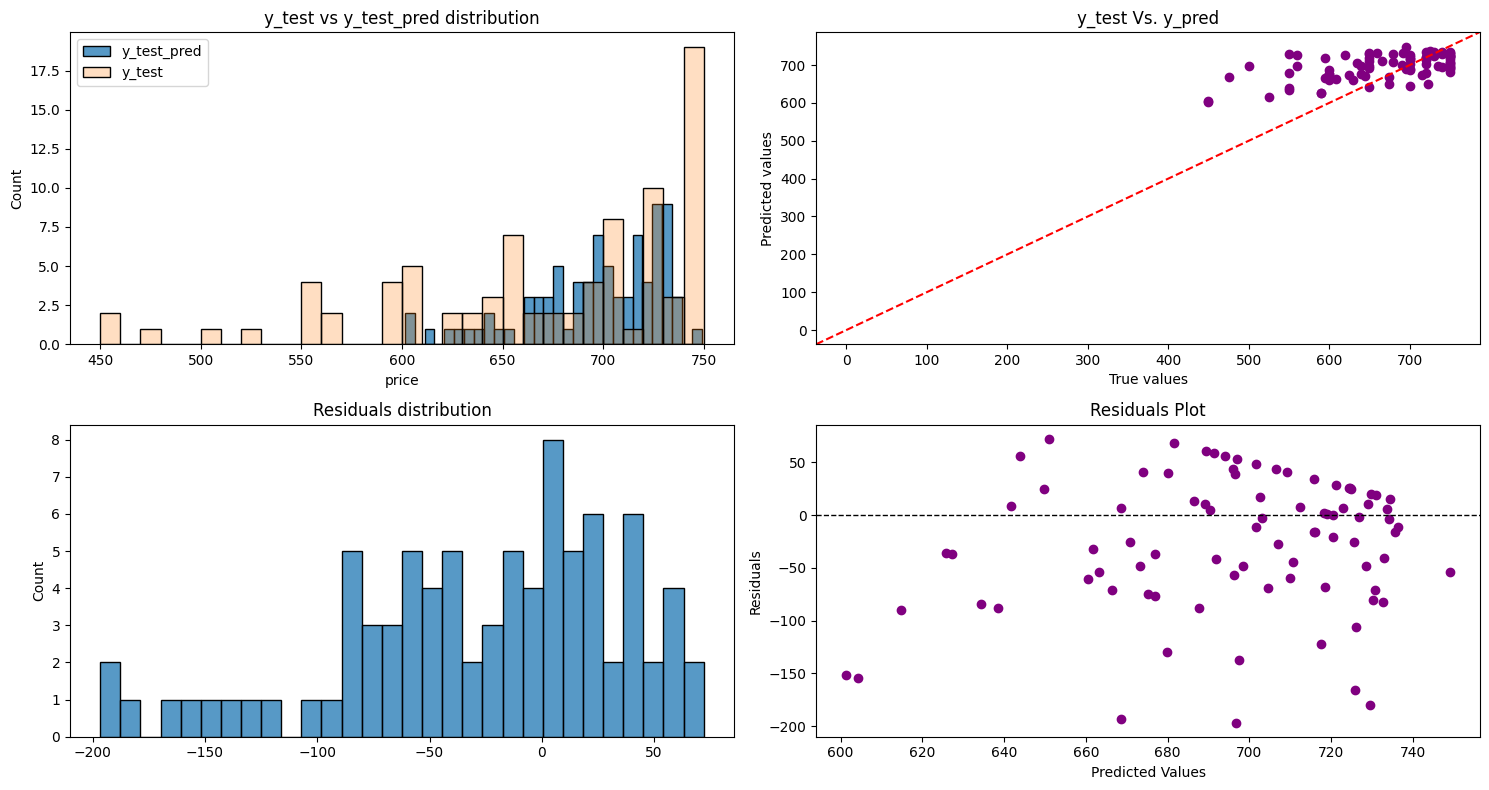

,r2_score,MAE,MSE,MSE_naive,RMSE
train,0.259976,34.106656,2055.705738,2777.889314,45.339891
test,0.183591,51.730070,4734.684987,5799.404844,68.809047


In [574]:
tag = ("pipeline_preprocessing", "RobustScaler + LinearRegression")

test_evaluate_model("priceByArea - baseline", best_model["best_pipeline"], X_train, y_train, X_test, y_test, tag=tag)

In [491]:
y_test_pred = pipeline.predict(X_test)

y_test_df = rent_df.iloc[y_test.index]

In [492]:
y_test_df["y_test_pred"] = y_test_pred
y_test_df["price_pred"] = y_test_df["y_test_pred"] * y_test_df["size"]
y_test_df

,index,numPhotos,price,propertyType,size,exterior,rooms,bathrooms,distance,priceByArea,hasPlan,hasLift,parkingSpace_included_in_listing,floor_grouped,municipality_grouped,reciprocal_size,size_transformed,distance_transformed,y_test_pred,price_pred
46,60,13,500.0,studio,28.0,False,0,1,769,17.857143,False,False,False,1,Madrid,0.035714,-1.795613,-1.913609,699.047423,19573.327834
163,200,31,740.0,flat,60.0,True,2,1,6670,12.333333,True,True,False,1,Madrid,0.016667,0.229647,-0.555699,703.145208,42188.712503
57,74,11,650.0,flat,65.0,False,2,1,11537,10.000000,False,False,False,3,Other,0.015385,0.453057,-0.052652,703.785487,45746.056682
25,33,12,750.0,penthouse,60.0,True,1,1,21316,12.500000,False,False,False,2,Other,0.016667,0.229647,0.614916,703.145208,42188.712503
113,142,35,750.0,flat,50.0,True,2,1,8331,15.000000,True,False,False,3,Madrid,0.020000,-0.271692,-0.361170,701.864650,35093.232517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,247,14,609.0,flat,56.0,True,1,1,30186,10.875000,True,True,False,0,Other,0.017857,0.038699,1.049674,702.632985,39347.447169
303,405,35,750.0,duplex,114.0,True,3 or more,2,28099,6.578947,False,False,False,1,Other,0.008772,2.077988,0.956515,710.060222,80946.865291
180,224,6,450.0,penthouse,60.0,True,1,1,53238,7.500000,False,False,False,unknown,Other,0.016667,0.229647,1.860229,703.145208,42188.712503
145,182,31,675.0,flat,76.0,True,3 or more,1,43485,8.881579,True,False,True,2,Other,0.013158,0.895262,1.555690,705.194101,53594.751696


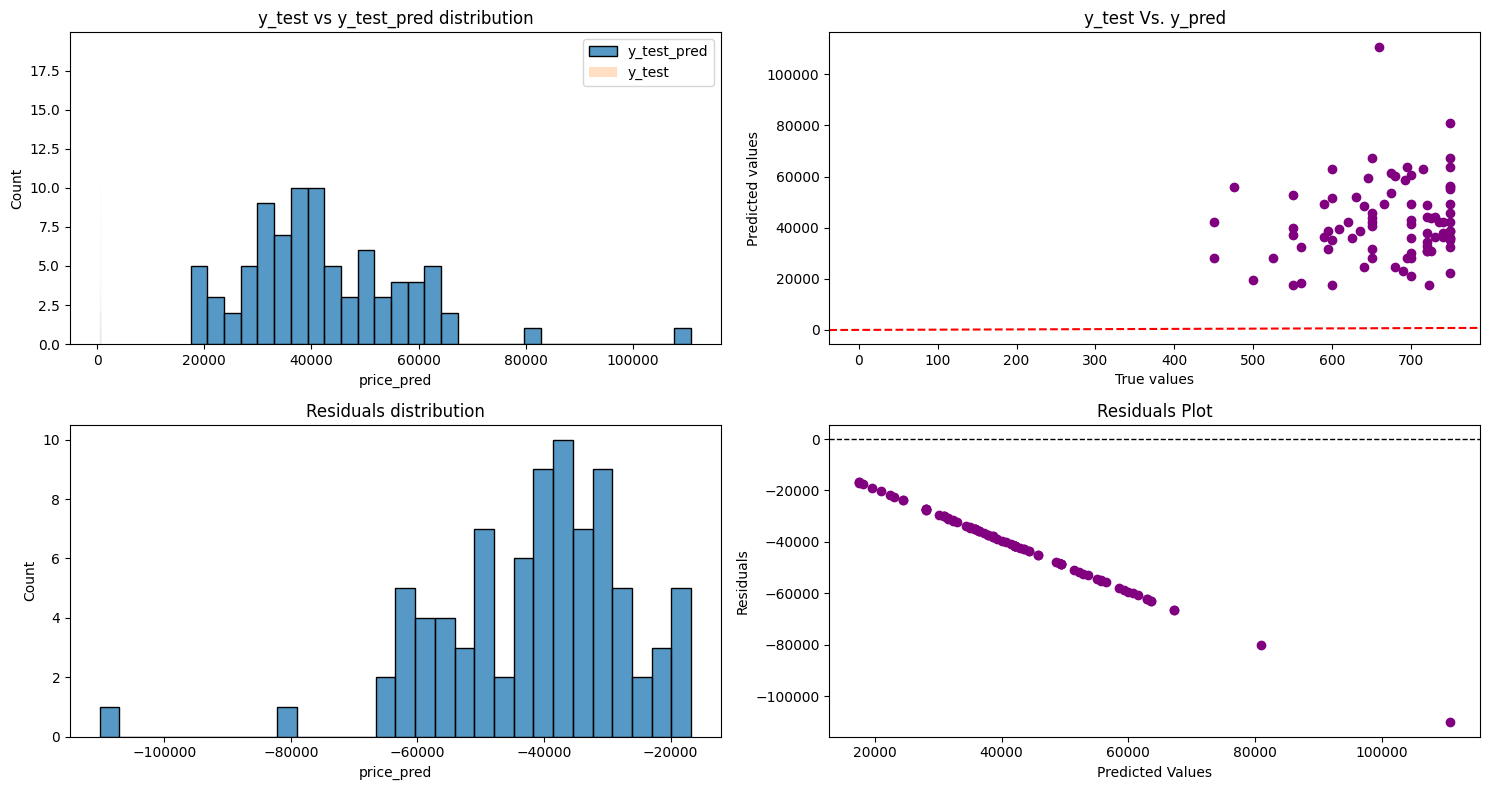

np.float64(44222.13214786906)

In [493]:
plot_prediction_residuals(y_test_df["price"],y_test_df["price_pred"])
root_mean_squared_error(y_test_df["price"],y_test_df["price_pred"])

In [494]:
y_test_pred

array([699.04742263, 703.14520838, 703.78548741, 703.14520838,
       701.86465033, 706.0904919 , 703.40131999, 707.62716155,
       700.58409229, 704.37454411, 707.62716155, 701.99270614,
       704.93798965, 702.50492936, 704.42576643, 706.85882673,
       706.47465931, 701.86465033, 705.45021287, 699.68770165,
       706.98688253, 704.29771063, 703.01715258, 703.14520838,
       705.06604546, 700.58409229, 698.66325521, 706.60271512,
       705.57826868, 704.80993385, 703.27326419, 698.79131102,
       699.55964585, 701.73659453, 705.70632448, 701.35242712,
       699.30353424, 704.42576643, 700.58409229, 702.76104097,
       703.78548741, 715.31050985, 702.50492936, 702.12076194,
       703.5293758 , 699.94381326, 703.5293758 , 698.66325521,
       701.22437131, 706.34660351, 701.09631551, 706.2185477 ,
       702.37687355, 703.14520838, 700.58409229, 701.99270614,
       698.66325521, 704.42576643, 699.94381326, 704.42576643,
       703.40131999, 700.9682597 , 700.58409229, 701.09

In [495]:
linear_regressor = pipeline.named_steps['regressor']

In [496]:
sns.scatterplot(rent_df,
                y="price_by_dist",
                x="reciprocal_distance")

ValueError: Could not interpret value `reciprocal_distance` for `x`. An entry with this name does not appear in `data`.

In [ ]:
coefficients = linear_regressor.coef_
intercept = linear_regressor.intercept_

print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [656.83230595]
Intercept: 0.010732826979619192
